# Data Analytics from a WhatsApp Group chat

This notebook analysis the whatsapp chat from a group of close friends. The purpose is to do basic data analytics such as what is the frequency of messages, who is most active when, but then if interest develops then can also explore advanced NLP topics.

## Setup up imports

In [1]:
library(glue)
library(dplyr)
library(tidyr)
library(purrr)
library(ggplot2)
library(GGally)
library(ggthemes)
library(tidyverse)
library(lubridate)
library(tidytext)
set.seed(1234)
library(wordcloud)


Attaching package: ‘dplyr’


The following object is masked from ‘package:glue’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘GGally’


The following object is masked from ‘package:dplyr’:

    nasa


Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ tibble  2.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse() masks glue::collapse()
✖ dplyr::filter()   masks stats::filte

## Global constants

In [16]:
RAW_DATA <- "preprocessed_raw_data2.txt" #preprocessed__chat2.txt
GUESS_MAX <- 20000
GROUP_NAME <- "Sample Group"
TIMESTAMP_FORMAT <- "MDY_HM" #"DMY_HMS" # or MDY_HM
TZ <- "America/New_York" #"Asia/Kolkata" # "America/New_York"

## Data Wrangling

In [17]:
# read the raw data
chat <- readr::read_csv(RAW_DATA, guess_max=GUESS_MAX)

Parsed with column specification:
cols(
  date = col_character(),
  timestamp = col_character(),
  sender = col_character(),
  message = col_character(),
  emojis = col_character()
)



In [18]:
head(chat, 10)

date,timestamp,sender,message,emojis
<chr>,<chr>,<chr>,<chr>,<chr>
1/1/20,1/1/20 9:54 PM,Person8,🙏,🙏
1/1/20,1/1/20 10:40 PM,Person8,<Media omitted>,NA
1/1/20,1/1/20 11:55 PM,Person4,Lol,NA
1/2/20,1/2/20 7:54 AM,Person2,Lol,NA
1/5/20,1/5/20 11:31 AM,Person8,<Media omitted>,NA
1/6/20,1/6/20 11:26 AM,Person1,Poonam respond karo for Lohri on 13th Jan,NA
1/6/20,1/6/20 11:43 AM,Person3,Haanji,NA
1/6/20,1/6/20 11:44 AM,Person4,"Nidhi, if you plan to order naan from outside then ask ppl to get paneer",NA
1/6/20,1/6/20 11:44 AM,Person4,Because naan ke saath sookhi sabji won’t go,NA


In [19]:
if (TIMESTAMP_FORMAT == "DMY_HMS") {
    chat <- chat %>%
      mutate(date = dmy(date), timestamp = dmy_hms(timestamp, tz=TZ))
} else if (TIMESTAMP_FORMAT == "MDY_HM")  {
    chat <- chat %>%
      mutate(date = mdy(date), timestamp = mdy_hm(timestamp, tz=TZ))   
} else {
    print("timestamp format needs to be set!!!")
}

head(chat)

date,timestamp,sender,message,emojis
<date>,<dttm>,<chr>,<chr>,<chr>
2020-01-01,2020-01-01 21:54:00,Person8,🙏,🙏
2020-01-01,2020-01-01 22:40:00,Person8,<Media omitted>,NA
2020-01-01,2020-01-01 23:55:00,Person4,Lol,NA
2020-01-02,2020-01-02 07:54:00,Person2,Lol,NA
2020-01-05,2020-01-05 11:31:00,Person8,<Media omitted>,NA
2020-01-06,2020-01-06 11:26:00,Person1,Poonam respond karo for Lohri on 13th Jan,NA


## Lets Explore 

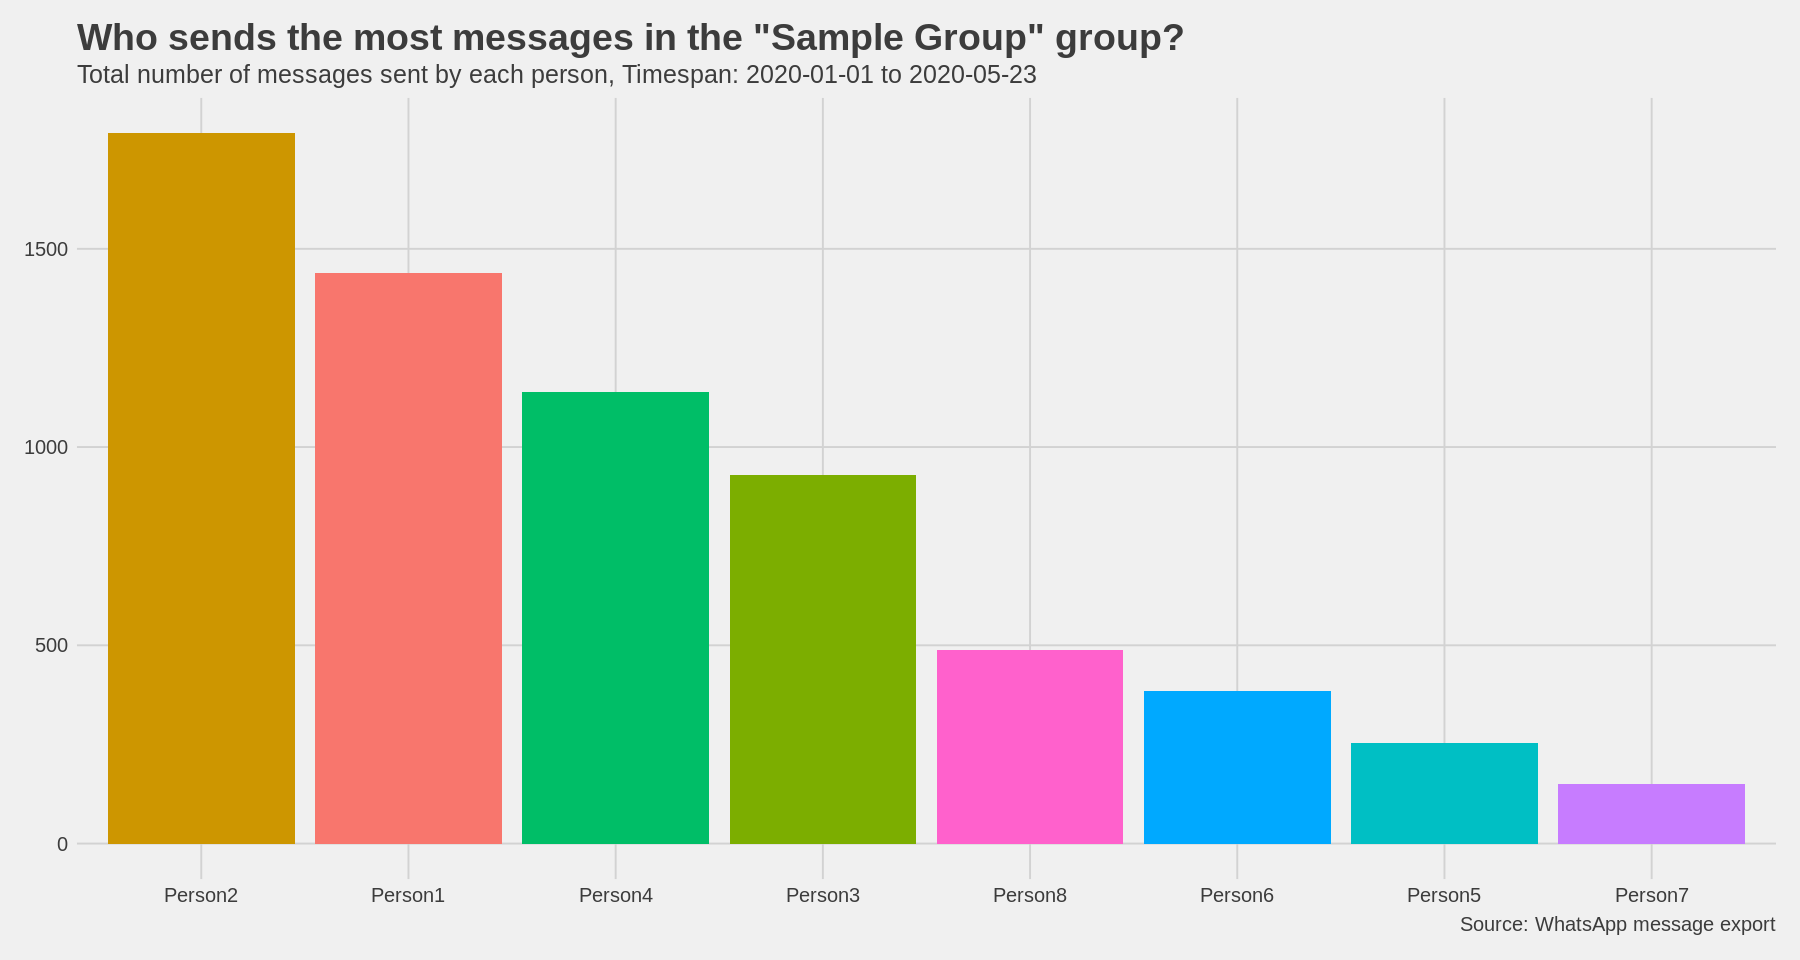

In [20]:
options(repr.plot.width=15, repr.plot.height=8)
chat %>% 
  count(sender, sort=TRUE) %>%
  ggplot(aes(x=reorder(sender, -n), y=n, fill=sender)) +
  geom_bar(position="dodge", stat="identity") +
  theme_fivethirtyeight() +
  xlab("") + 
  labs(title=glue("Who sends the most messages in the \"{GROUP_NAME}\" group?"),
       subtitle=glue("Total number of messages sent by each person, Timespan: {min(chat$date)} to {max(chat$date)}"),
       caption="Source: WhatsApp message export") +
  theme(text = element_text(size=15), legend.position = "none") +
  scale_color_tableau()

### Frequency of messages per day

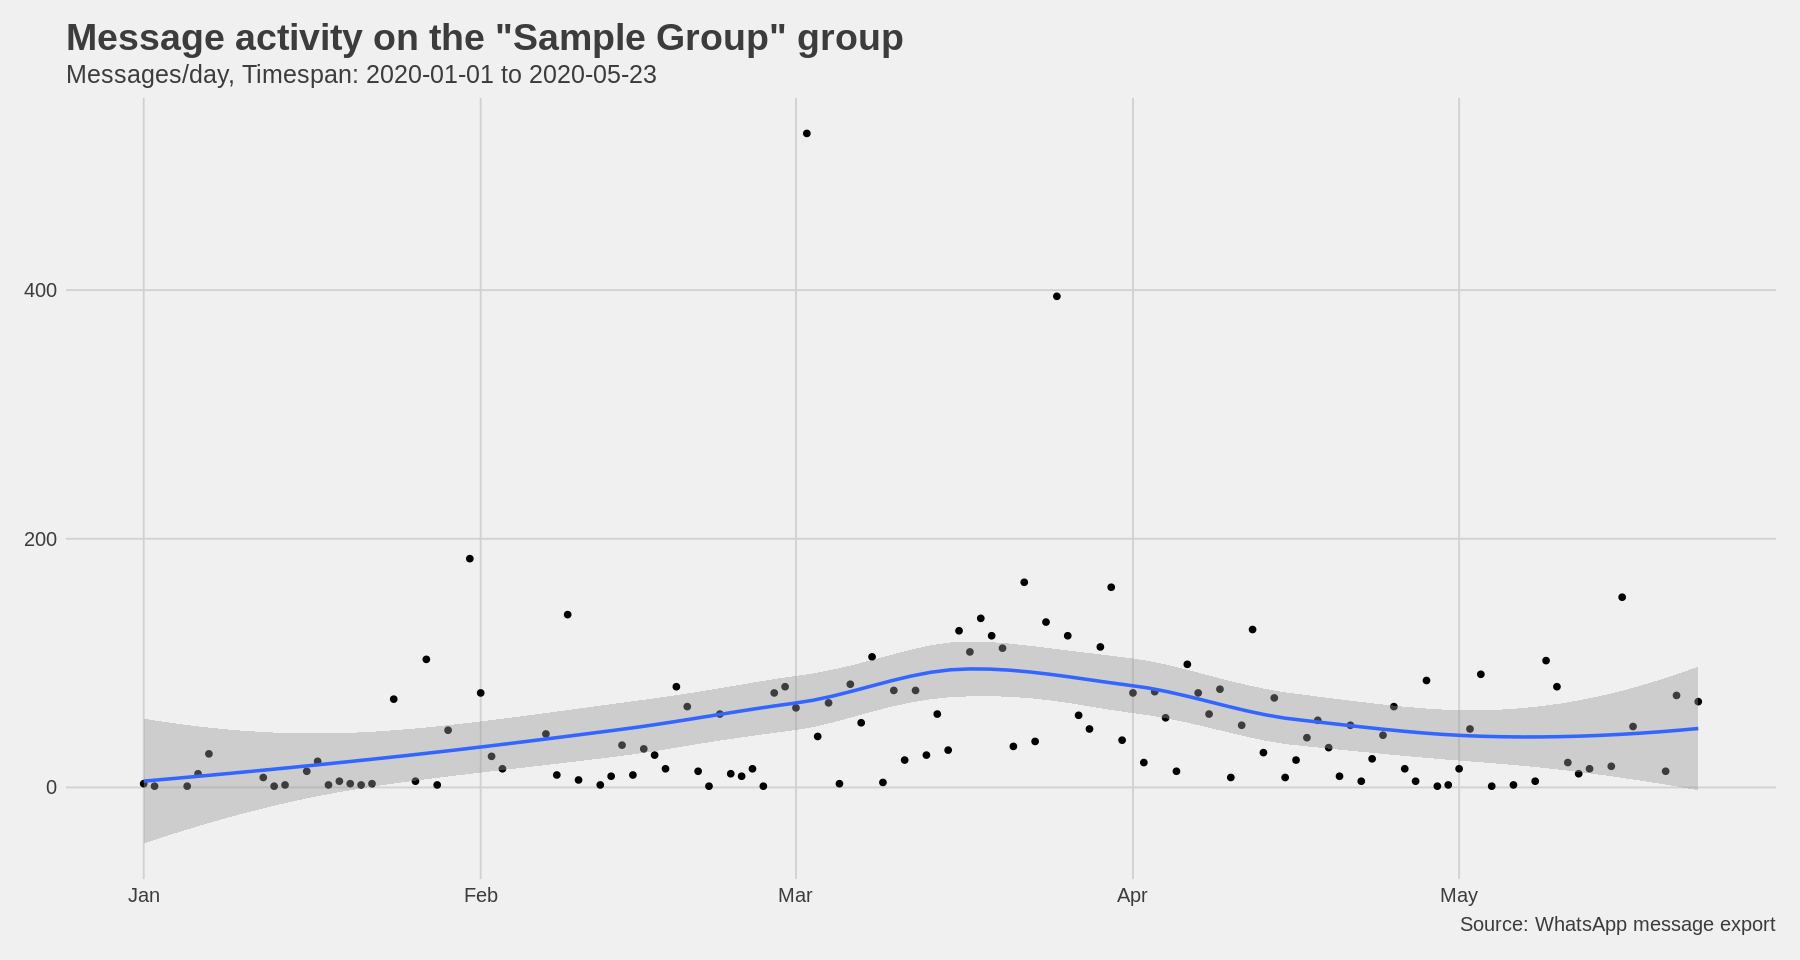

In [21]:
options(repr.plot.width=15, repr.plot.height=8)

p <- chat %>%
  count(date) %>%
  ggplot(aes(x=date, y=n)) +
  geom_point() + 
  stat_smooth(method = "loess", formula = y ~ x, size = 1) + 
  theme_fivethirtyeight() +
  xlab("") + 
  ylab("Messages/day") + 
  labs(title=glue("Message activity on the \"{GROUP_NAME}\" group"),
       subtitle=glue("Messages/day, Timespan: {min(chat$date)} to {max(chat$date)}"),
       caption="Source: WhatsApp message export") +
  theme(text = element_text(size=15))


p

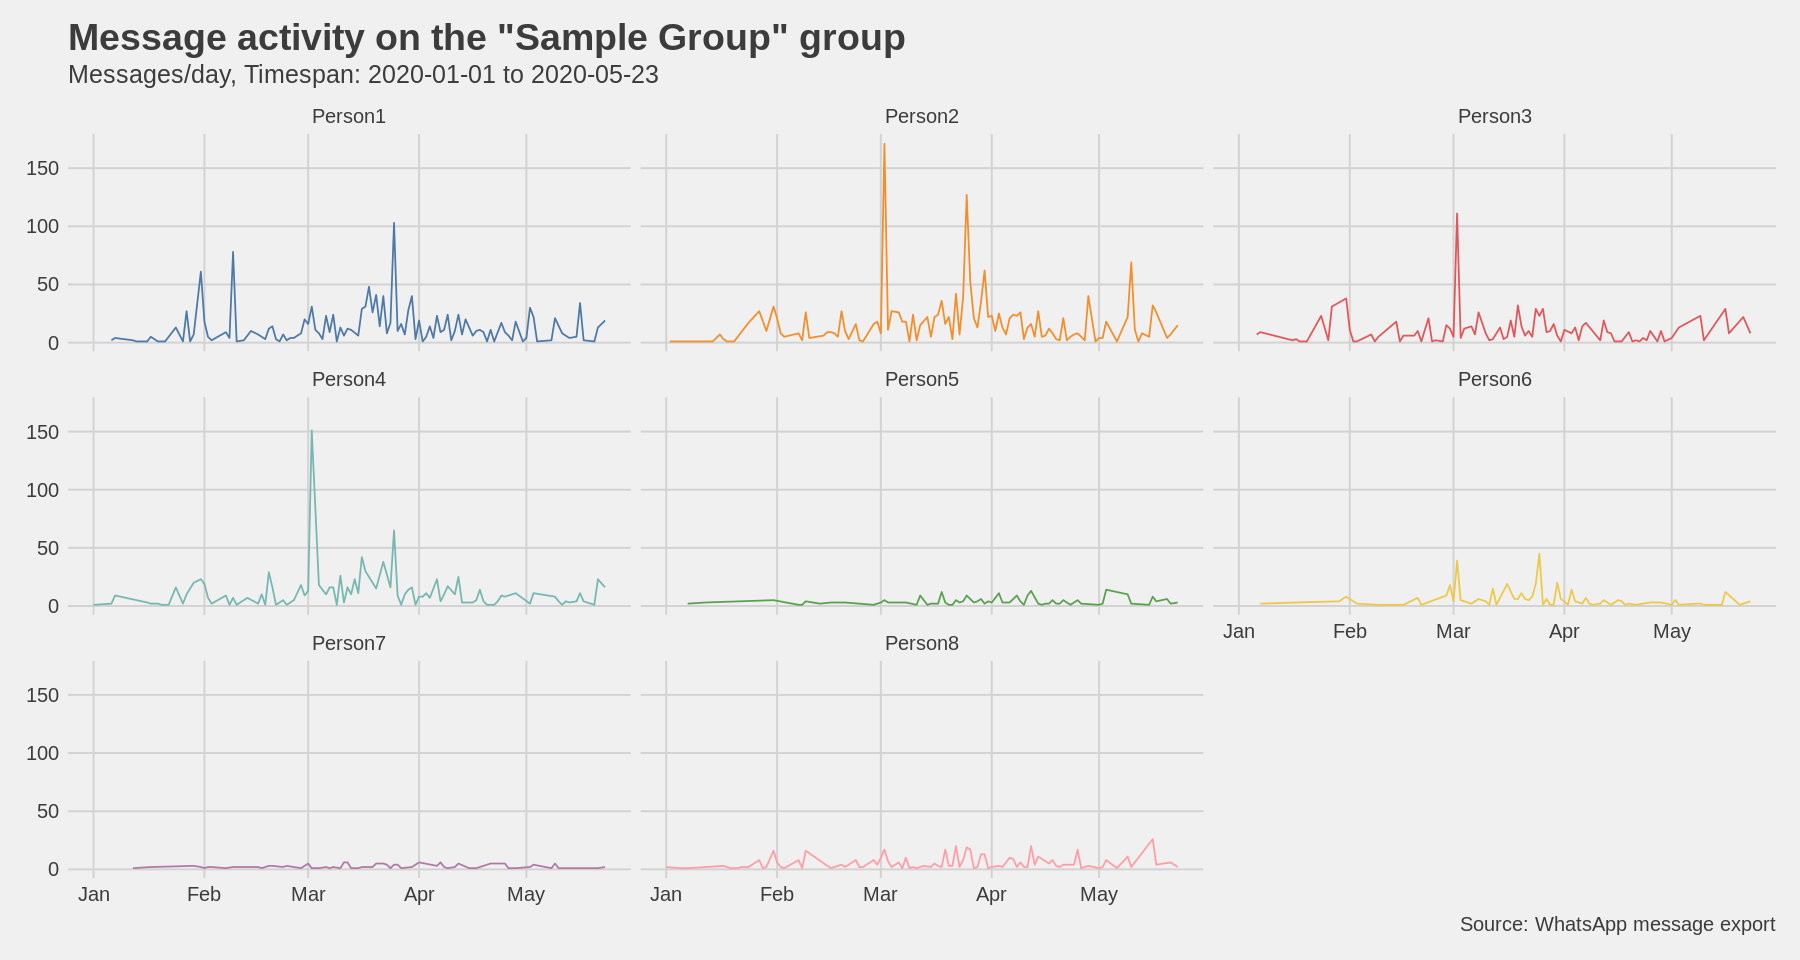

In [22]:
options(repr.plot.width=15, repr.plot.height=8)

p <- chat %>%
  count(sender, date) %>%
  ggplot(aes(x=date, y=n, col=sender)) +
  geom_line() +
  facet_wrap(~sender) +
  theme_fivethirtyeight() + 
  xlab("") + 
  ylab("Messages/day") + 
  labs(title=glue("Message activity on the \"{GROUP_NAME}\" group"),
       subtitle=glue("Messages/day, Timespan: {min(chat$date)} to {max(chat$date)}"),
       caption="Source: WhatsApp message export") +
  theme(text = element_text(size=15), legend.position = "none") + 
  scale_color_tableau()
p

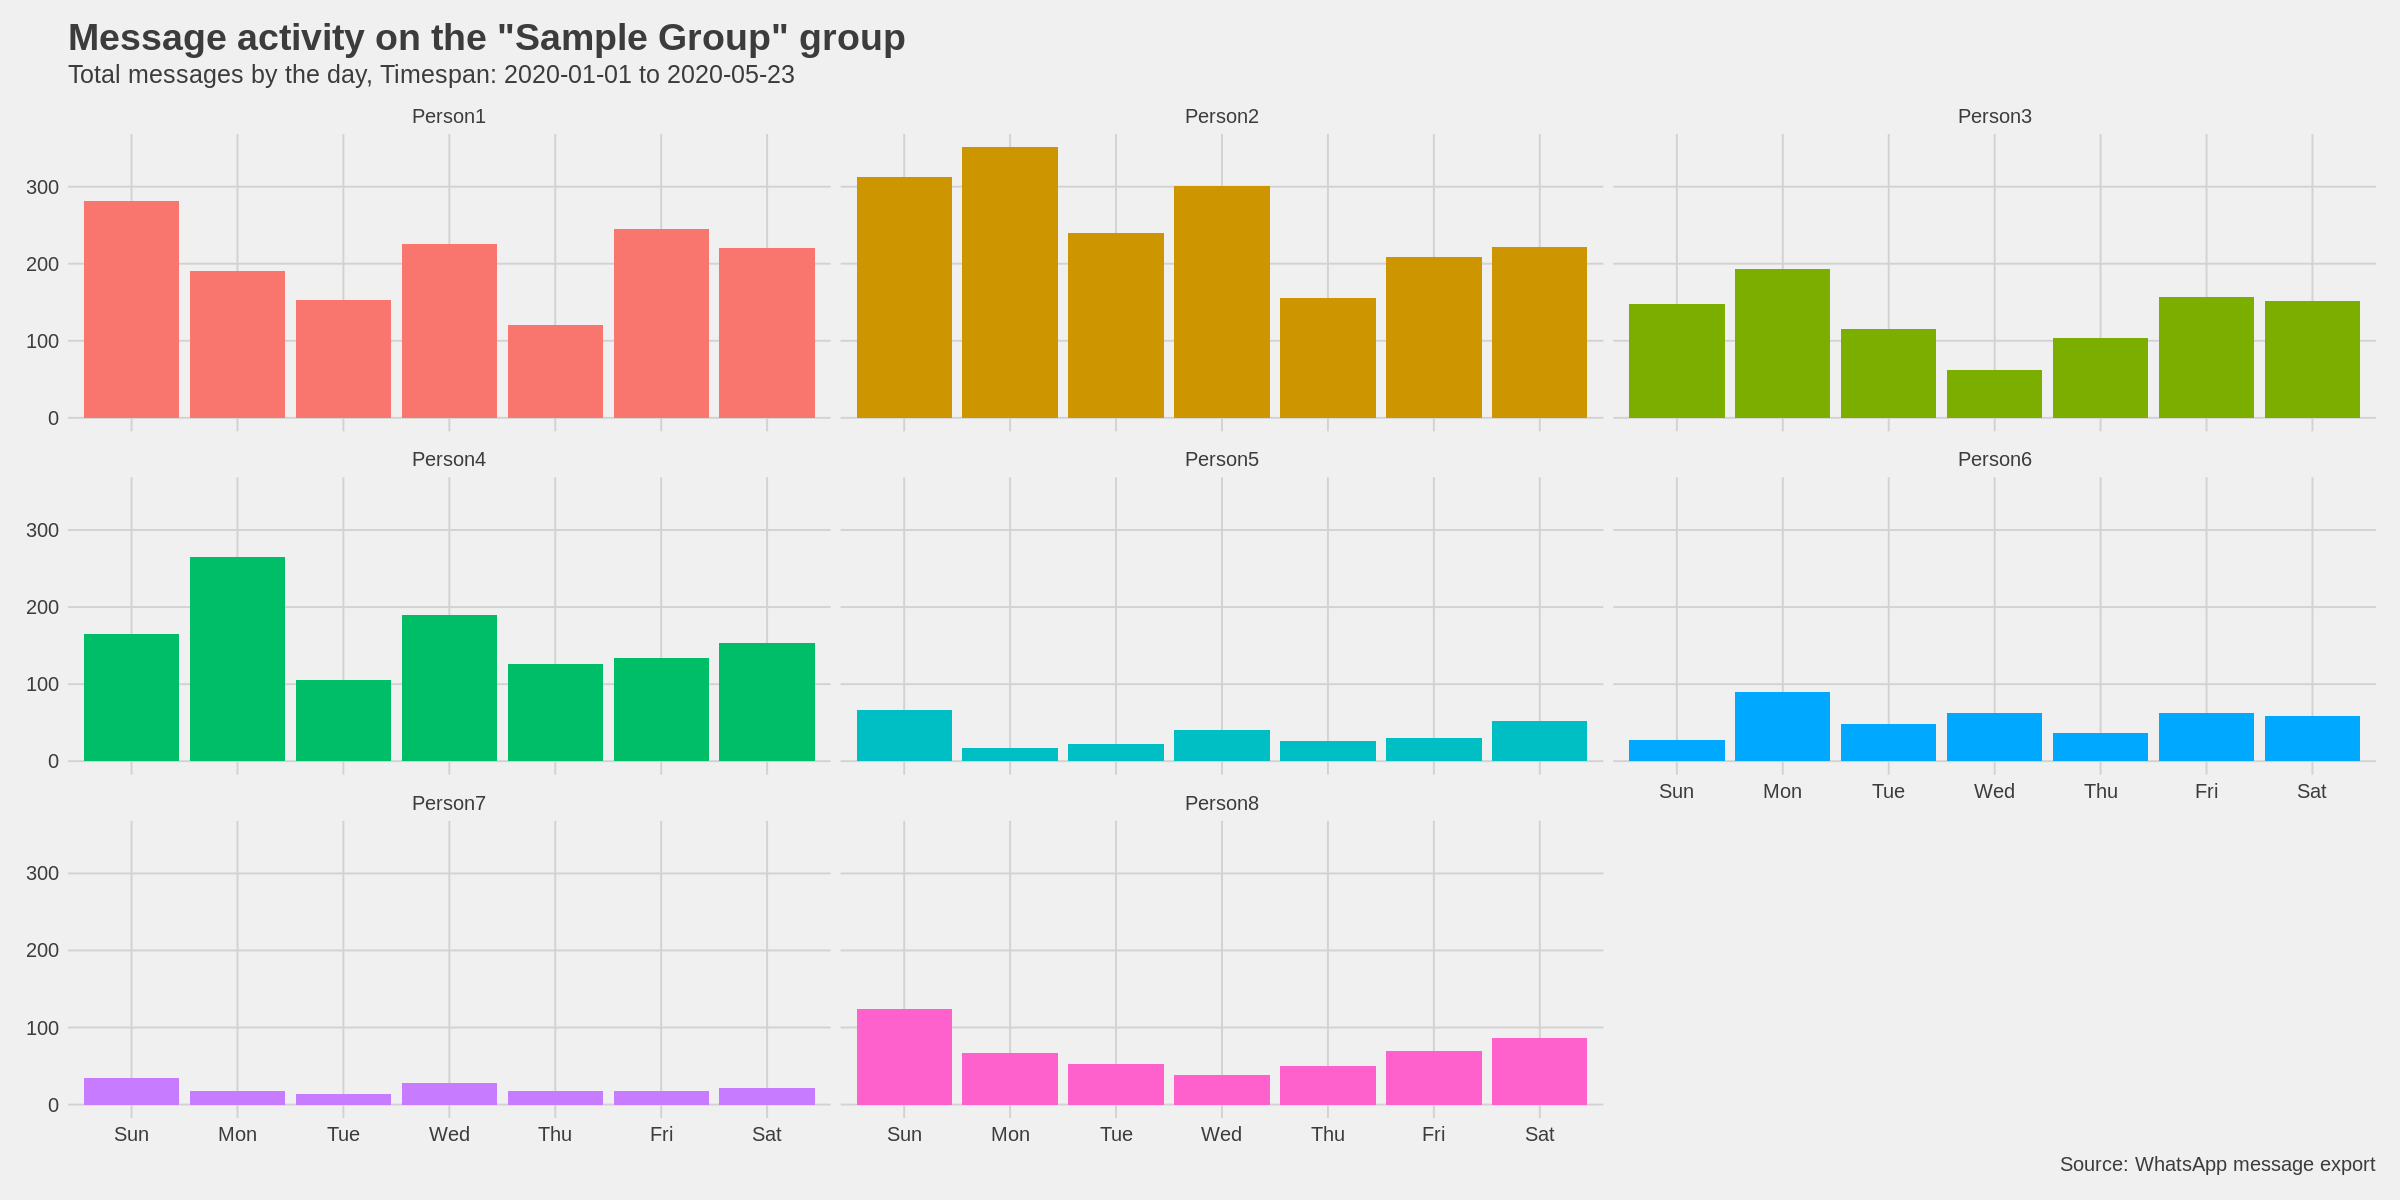

In [23]:
options(repr.plot.width=20, repr.plot.height=10)

p <- chat %>%
  mutate(day_of_the_week=wday(date, label=TRUE)) %>%
  count(day_of_the_week, sender) %>%
  ggplot(aes(x=day_of_the_week, y=n, fill=sender)) +
  geom_bar(position="dodge", stat="identity") +
  theme_fivethirtyeight() +
  xlab("") + 
  ylab("Messages/day") + 
  labs(title=glue("Message activity on the \"{GROUP_NAME}\" group"),
       subtitle=glue("Total messages by the day, Timespan: {min(chat$date)} to {max(chat$date)}"),
       caption="Source: WhatsApp message export") +
  theme(text = element_text(size=15), legend.position = "none") + 
  facet_wrap(~sender) +
  scale_color_tableau()
p

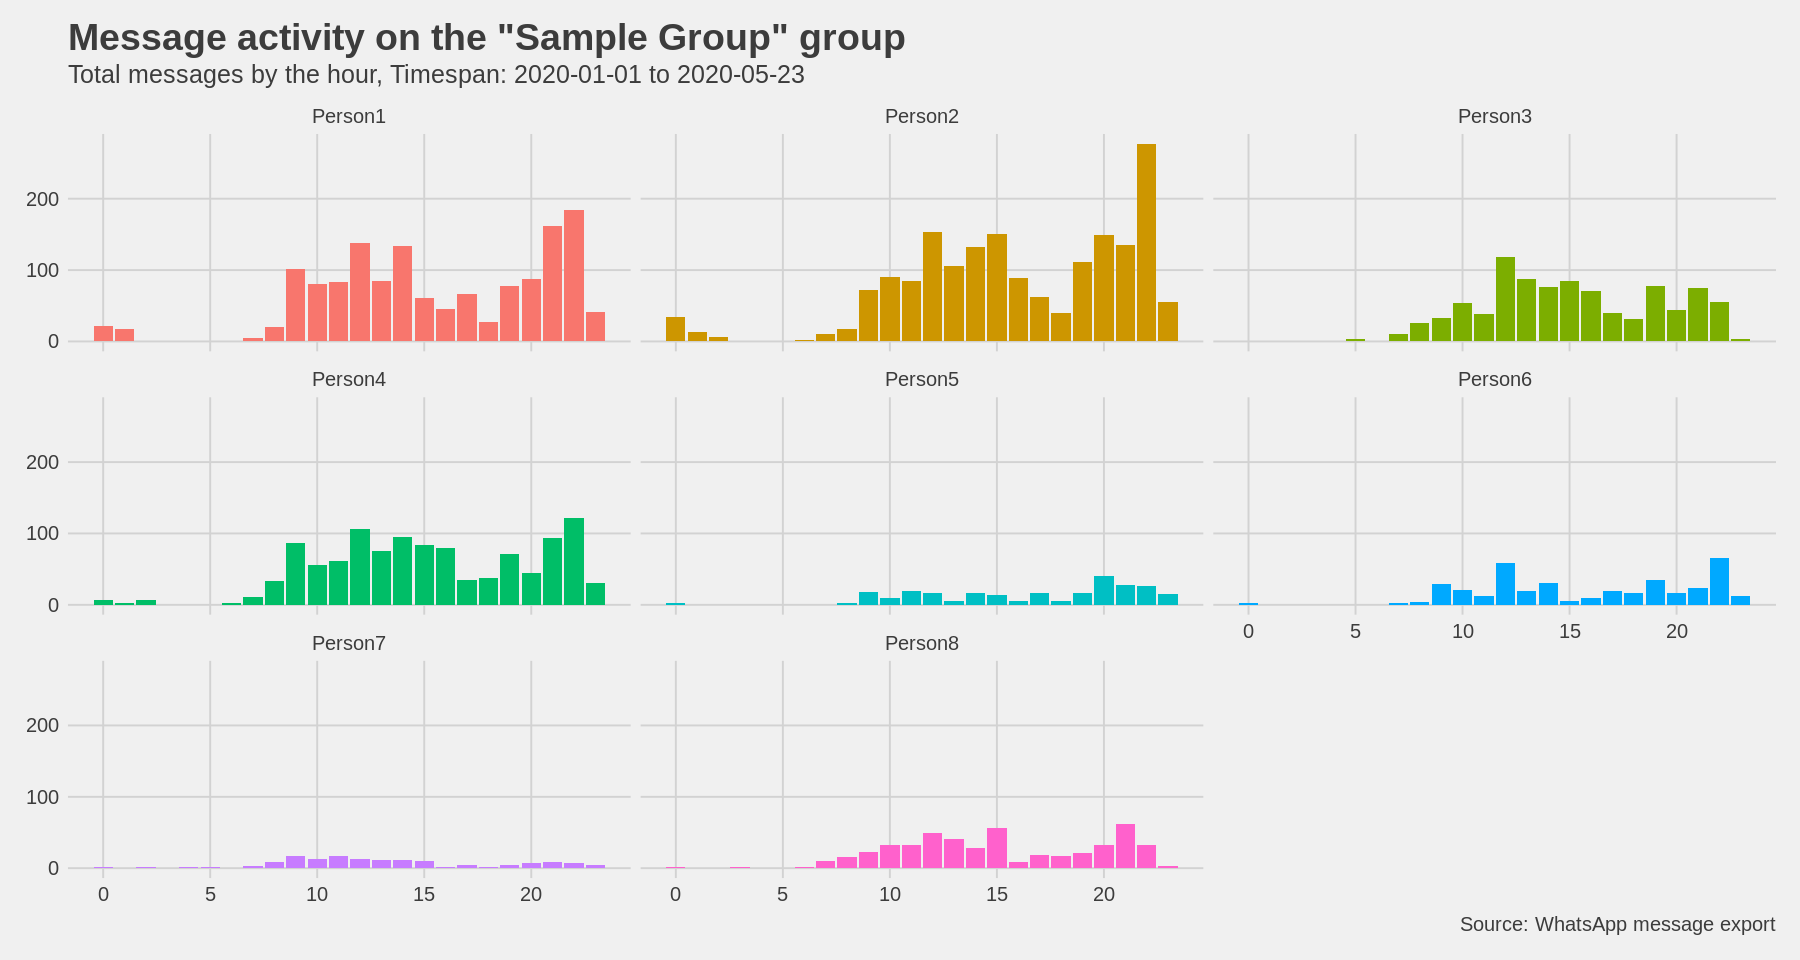

In [24]:
options(repr.plot.width=15, repr.plot.height=8)

p <- chat %>%
  mutate(hour=hour(timestamp)) %>%
  count(hour, sender) %>%
  ggplot(aes(x=hour, y=n, fill=sender)) +
  geom_bar(position="dodge", stat="identity") +
  theme_fivethirtyeight() +
  xlab("") + 
  ylab("Messages/hour") + 
  labs(title=glue("Message activity on the \"{GROUP_NAME}\" group"),
       subtitle=glue("Total messages by the hour, Timespan: {min(chat$date)} to {max(chat$date)}"),
       caption="Source: WhatsApp message export") +
  theme(text = element_text(size=15), legend.position = "none") + 
  facet_wrap(~sender) +
  scale_color_tableau()
p

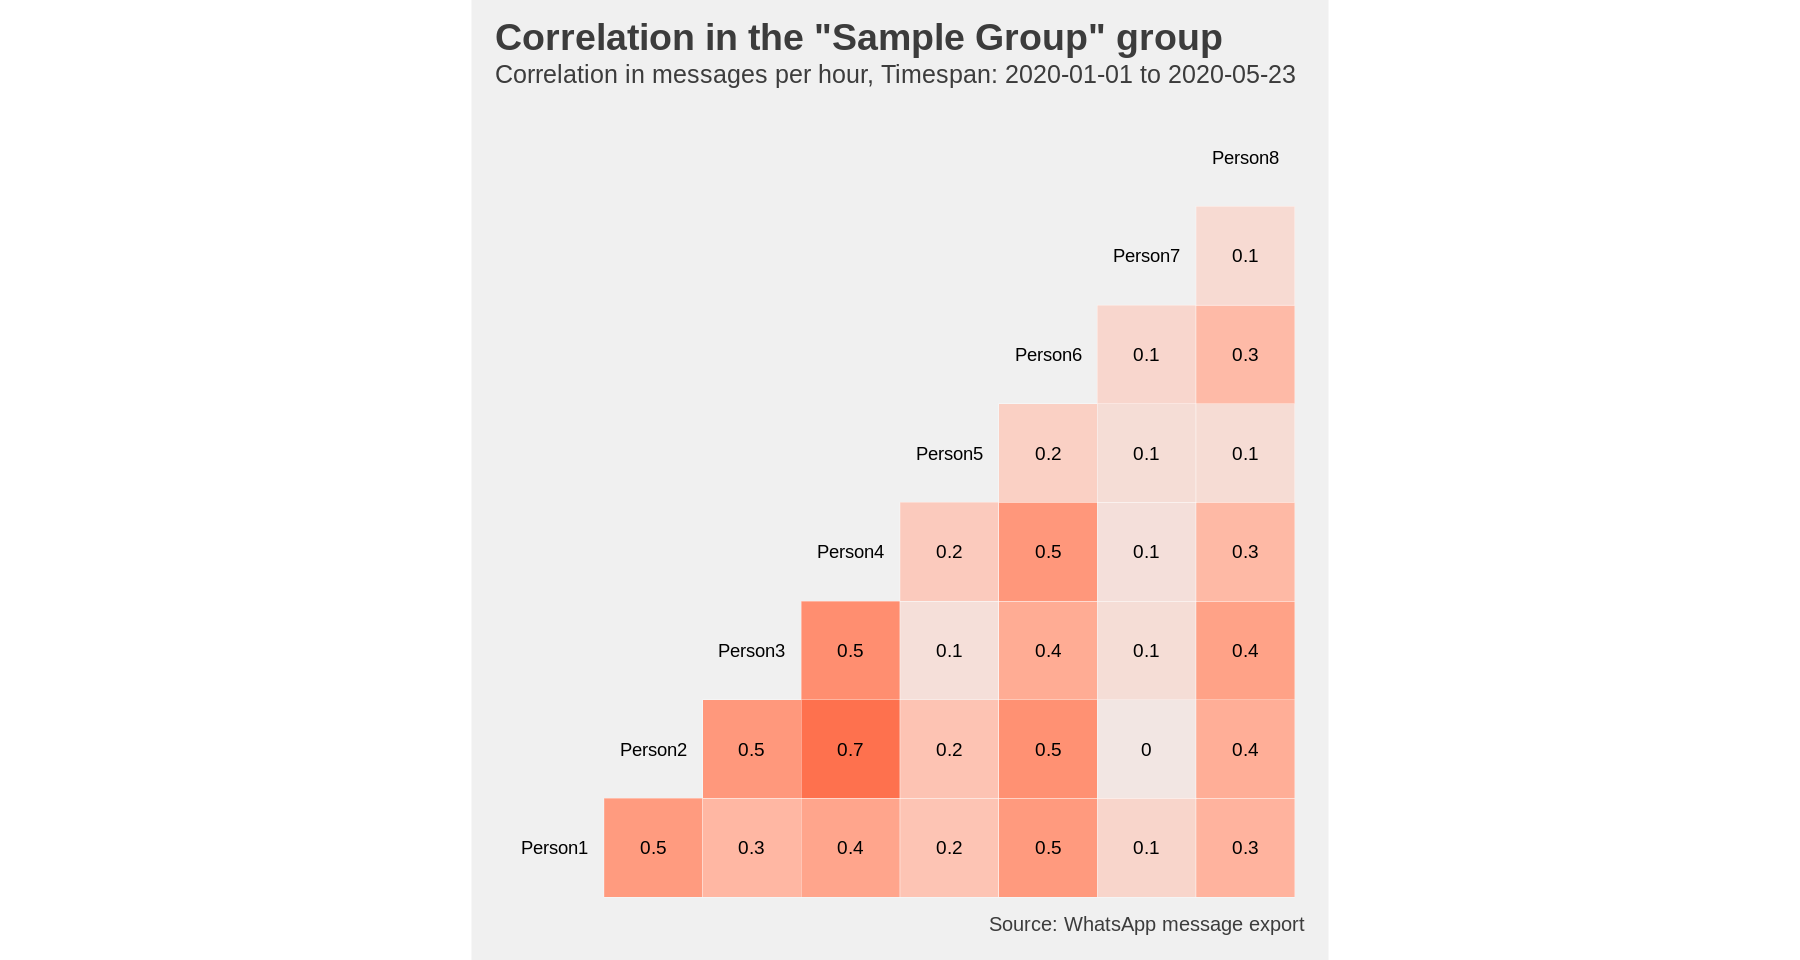

In [25]:
#options(repr.plot.width=10, repr.plot.height=8)
chat_mv_timeseries <- chat %>%
  mutate(hour=round_date(timestamp, unit="hour")) %>%
  count(hour, sender) %>%
  spread(sender, n) %>%
  replace(is.na(.), 0) %>%
  select(-hour)

p <- ggcorr(chat_mv_timeseries, method = c("everything", "pearson"), label=TRUE) +
  theme_fivethirtyeight() +
  labs(title=glue("Correlation in the \"{GROUP_NAME}\" group"),
       subtitle=glue("Correlation in messages per hour, Timespan: {min(chat$date)} to {max(chat$date)}"),
       caption="Source: WhatsApp message export") +
  theme(text = element_text(size=15), legend.position = "none") +
  scale_color_tableau()
p


Warning message:
“Grouping rowwise data frame strips rowwise nature”


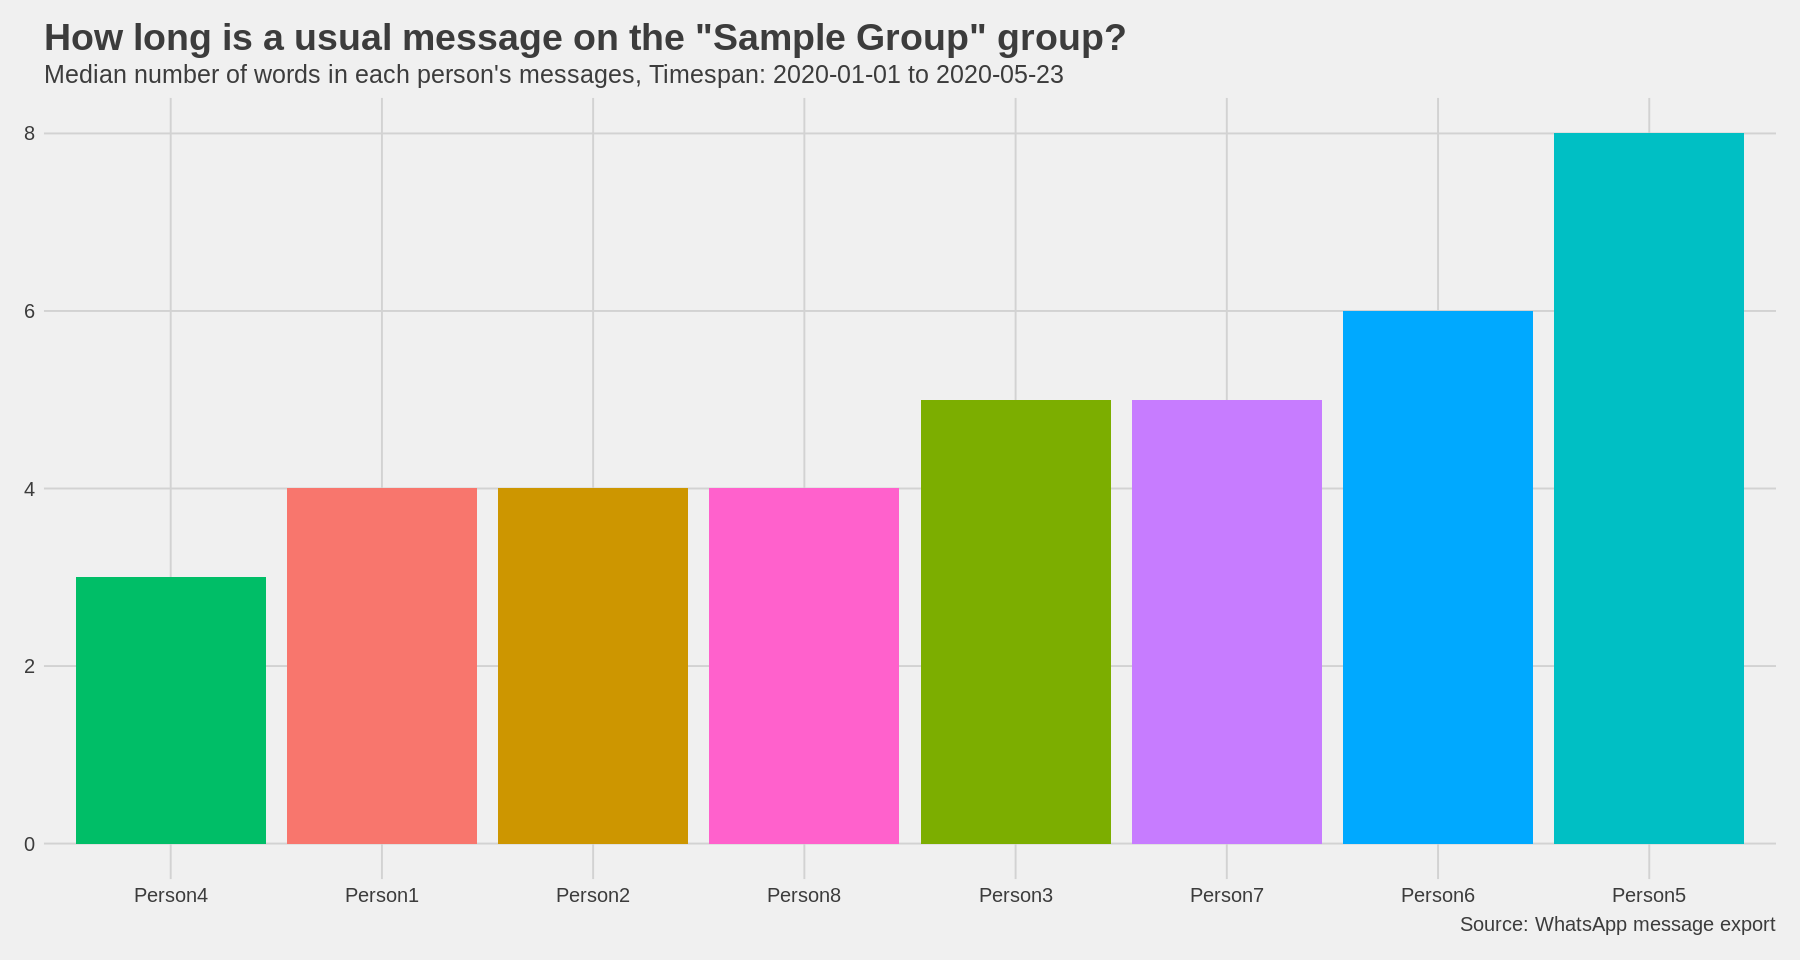

In [26]:
options(repr.plot.width=15, repr.plot.height=8)
chat_message_len <- chat %>%
  mutate(sender = str_trim(sender)) %>%
  rowwise() %>%
  mutate(num_of_words = length(str_split(message, " ", simplify = TRUE))) %>%
  select(sender, num_of_words) %>%
  group_by(sender) %>%
  summarize(num_of_words = quantile(num_of_words, 0.5)) %>%
  ungroup()

chat_message_len %>%
  ggplot(aes(x=reorder(sender, num_of_words), y=num_of_words, fill=sender)) +
  geom_bar(position="dodge", stat="identity") +
  theme_fivethirtyeight() +
  xlab("") + 
  ylab("Messages/hour") + 
  labs(title=glue("How long is a usual message on the \"{GROUP_NAME}\" group?"),
       subtitle=glue("Median number of words in each person's messages, Timespan: {min(chat$date)} to {max(chat$date)}"),
       caption="Source: WhatsApp message export") +
  theme(text = element_text(size=15), legend.position = "none") +
  scale_color_tableau()


Joining, by = "word"

Selecting by n



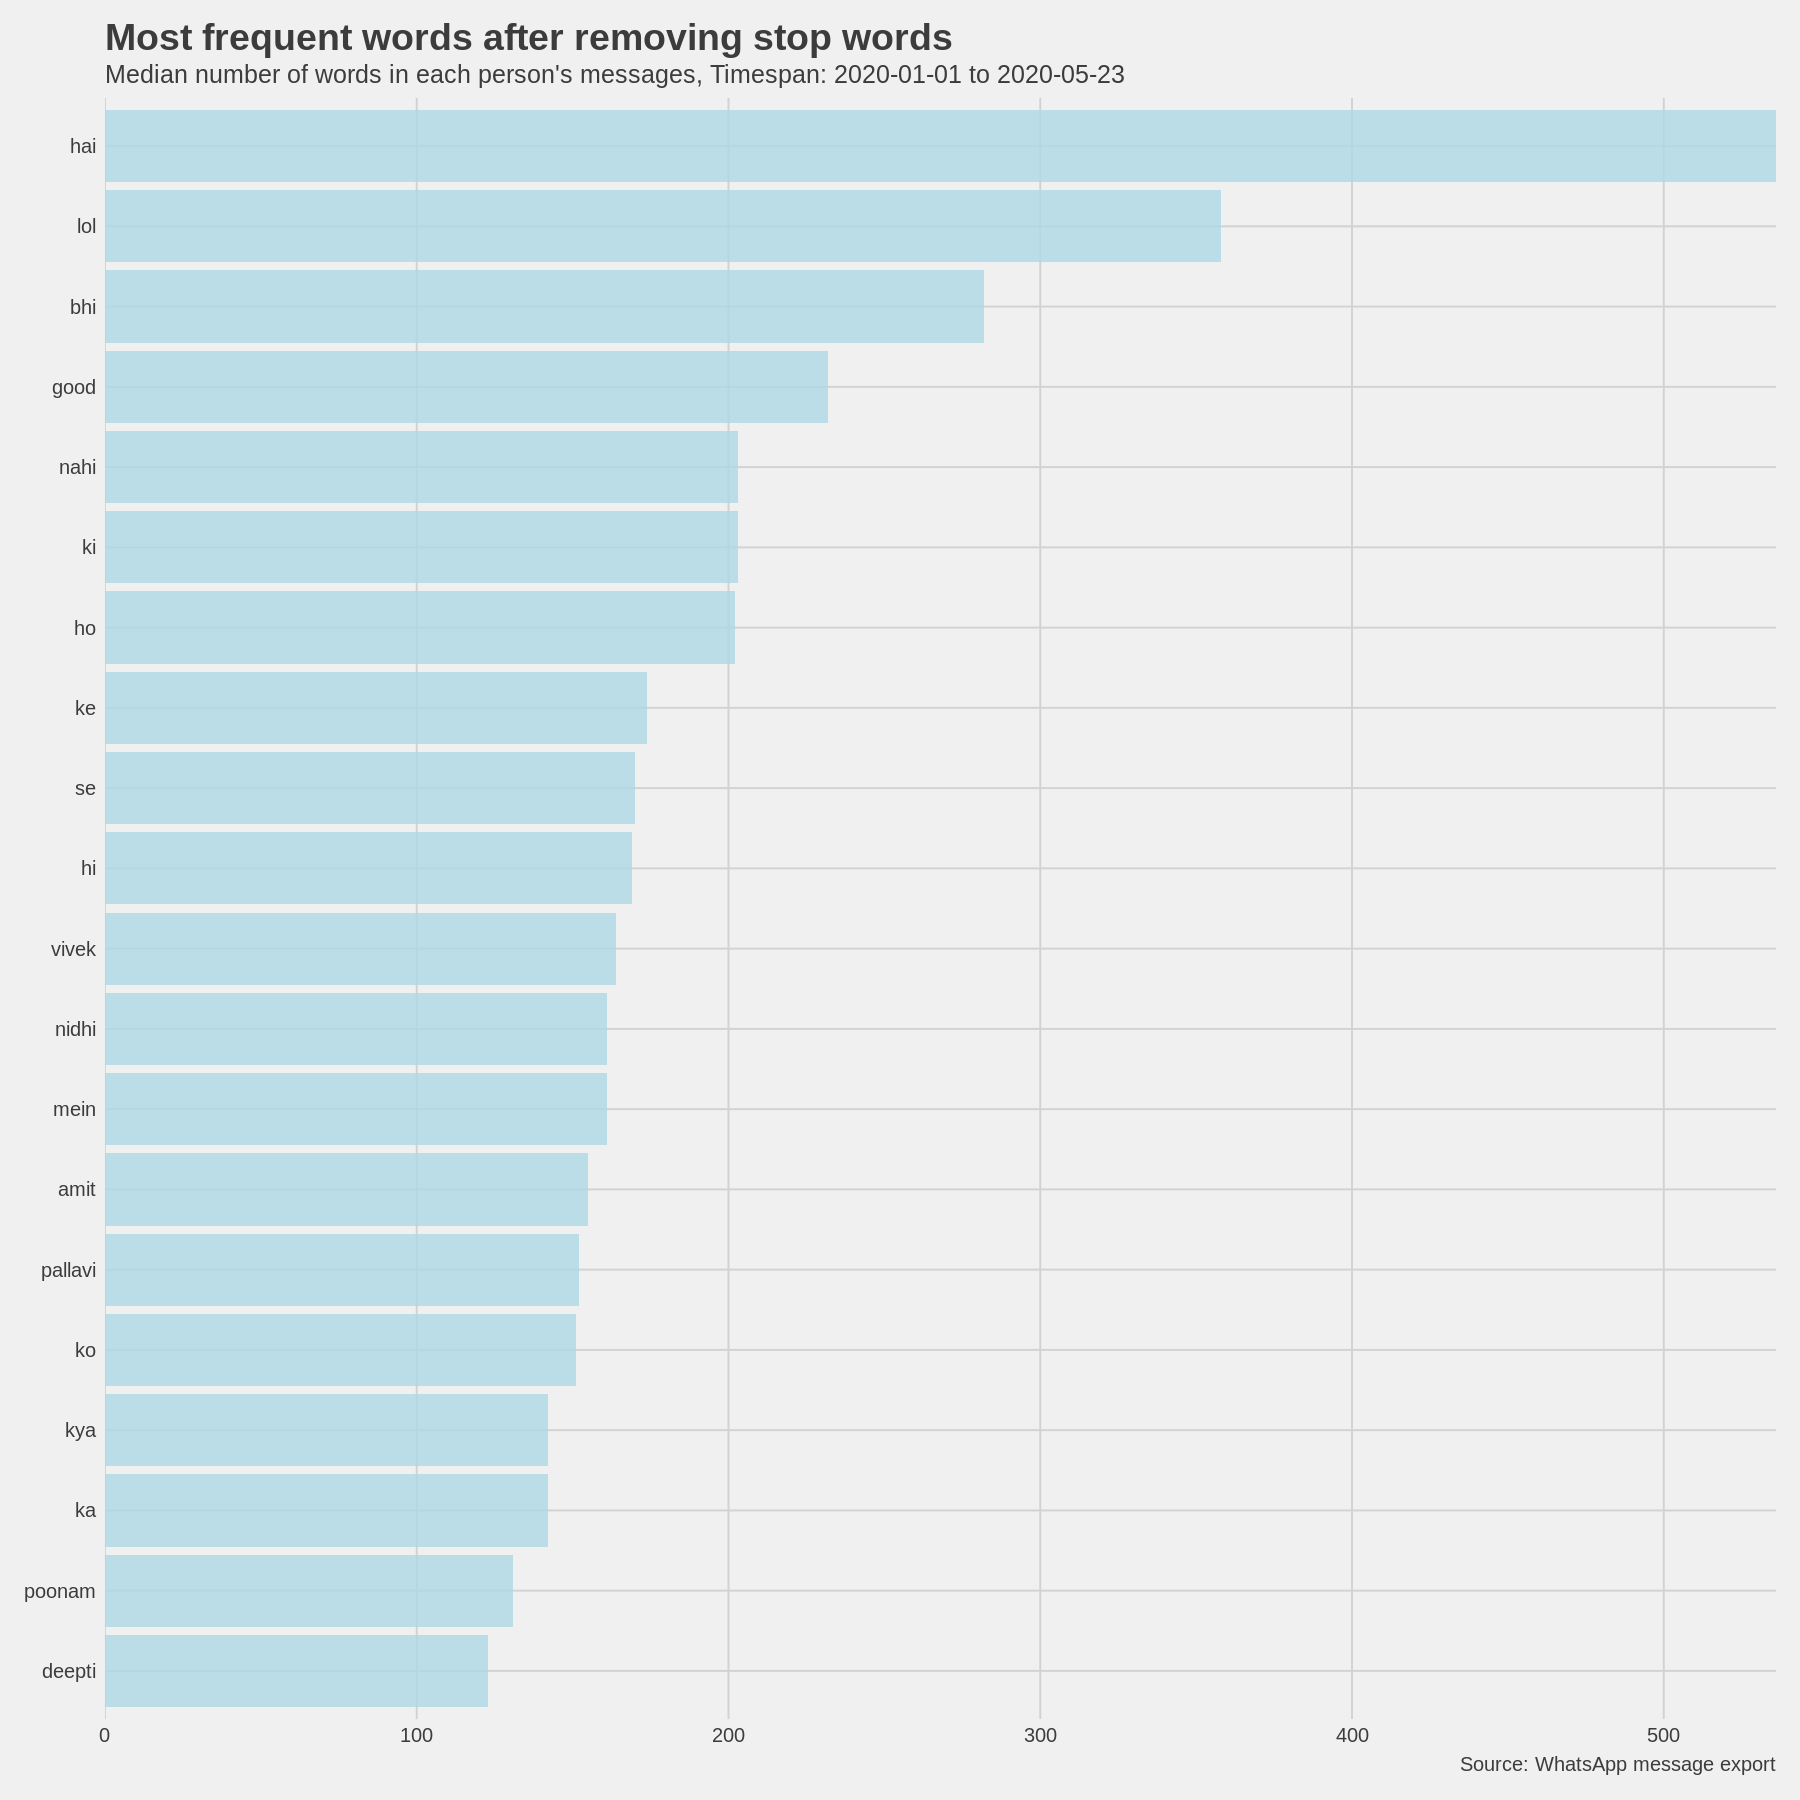

In [27]:
options(repr.plot.width=15, repr.plot.height=15)
tidy_chat <- chat %>%
  select(message) %>%
  unnest_tokens(word, message) %>%
  group_by(word) %>%
  ungroup()

tidy_chat %>%
  count(word, sort=T) %>%
  filter(!(word %in% c("media", "omitted"))) %>%
  anti_join(get_stopwords()) %>%
  top_n(20) %>%
  ungroup() %>%
  ggplot(aes(x=reorder(word, n), y=n,
    fill = I("lightblue")
  )) +
  geom_col(alpha = 0.8, show.legend = FALSE) +
  coord_flip() +

  scale_y_continuous(expand = c(0, 0)) +
  labs(
    x = NULL, y = "Word count",
    title = "Most frequent words after removing stop words",
    subtitle = glue("Median number of words in each person's messages, Timespan: {min(chat$date)} to {max(chat$date)}"),
      caption="Source: WhatsApp message export"
  ) + 
theme_fivethirtyeight() +
  theme(text = element_text(size=15), legend.position = "none") +
  scale_color_tableau()

In [28]:
chat %>%
  select(message) %>%
  unnest_tokens(bigram, message, token = "ngrams", n = 2) %>%
  filter(!str_detect(bigram, "omitted") & !str_detect(bigram, "deleted") & !str_detect(bigram, "message")) %>%
  count(bigram, sort=TRUE)


bigram,n
<chr>,<int>
i am,112
thank you,77
i will,70
i have,58
in the,46
this is,42
for the,41
it was,41
ke liye,38


Joining, by = "word"

Selecting by n



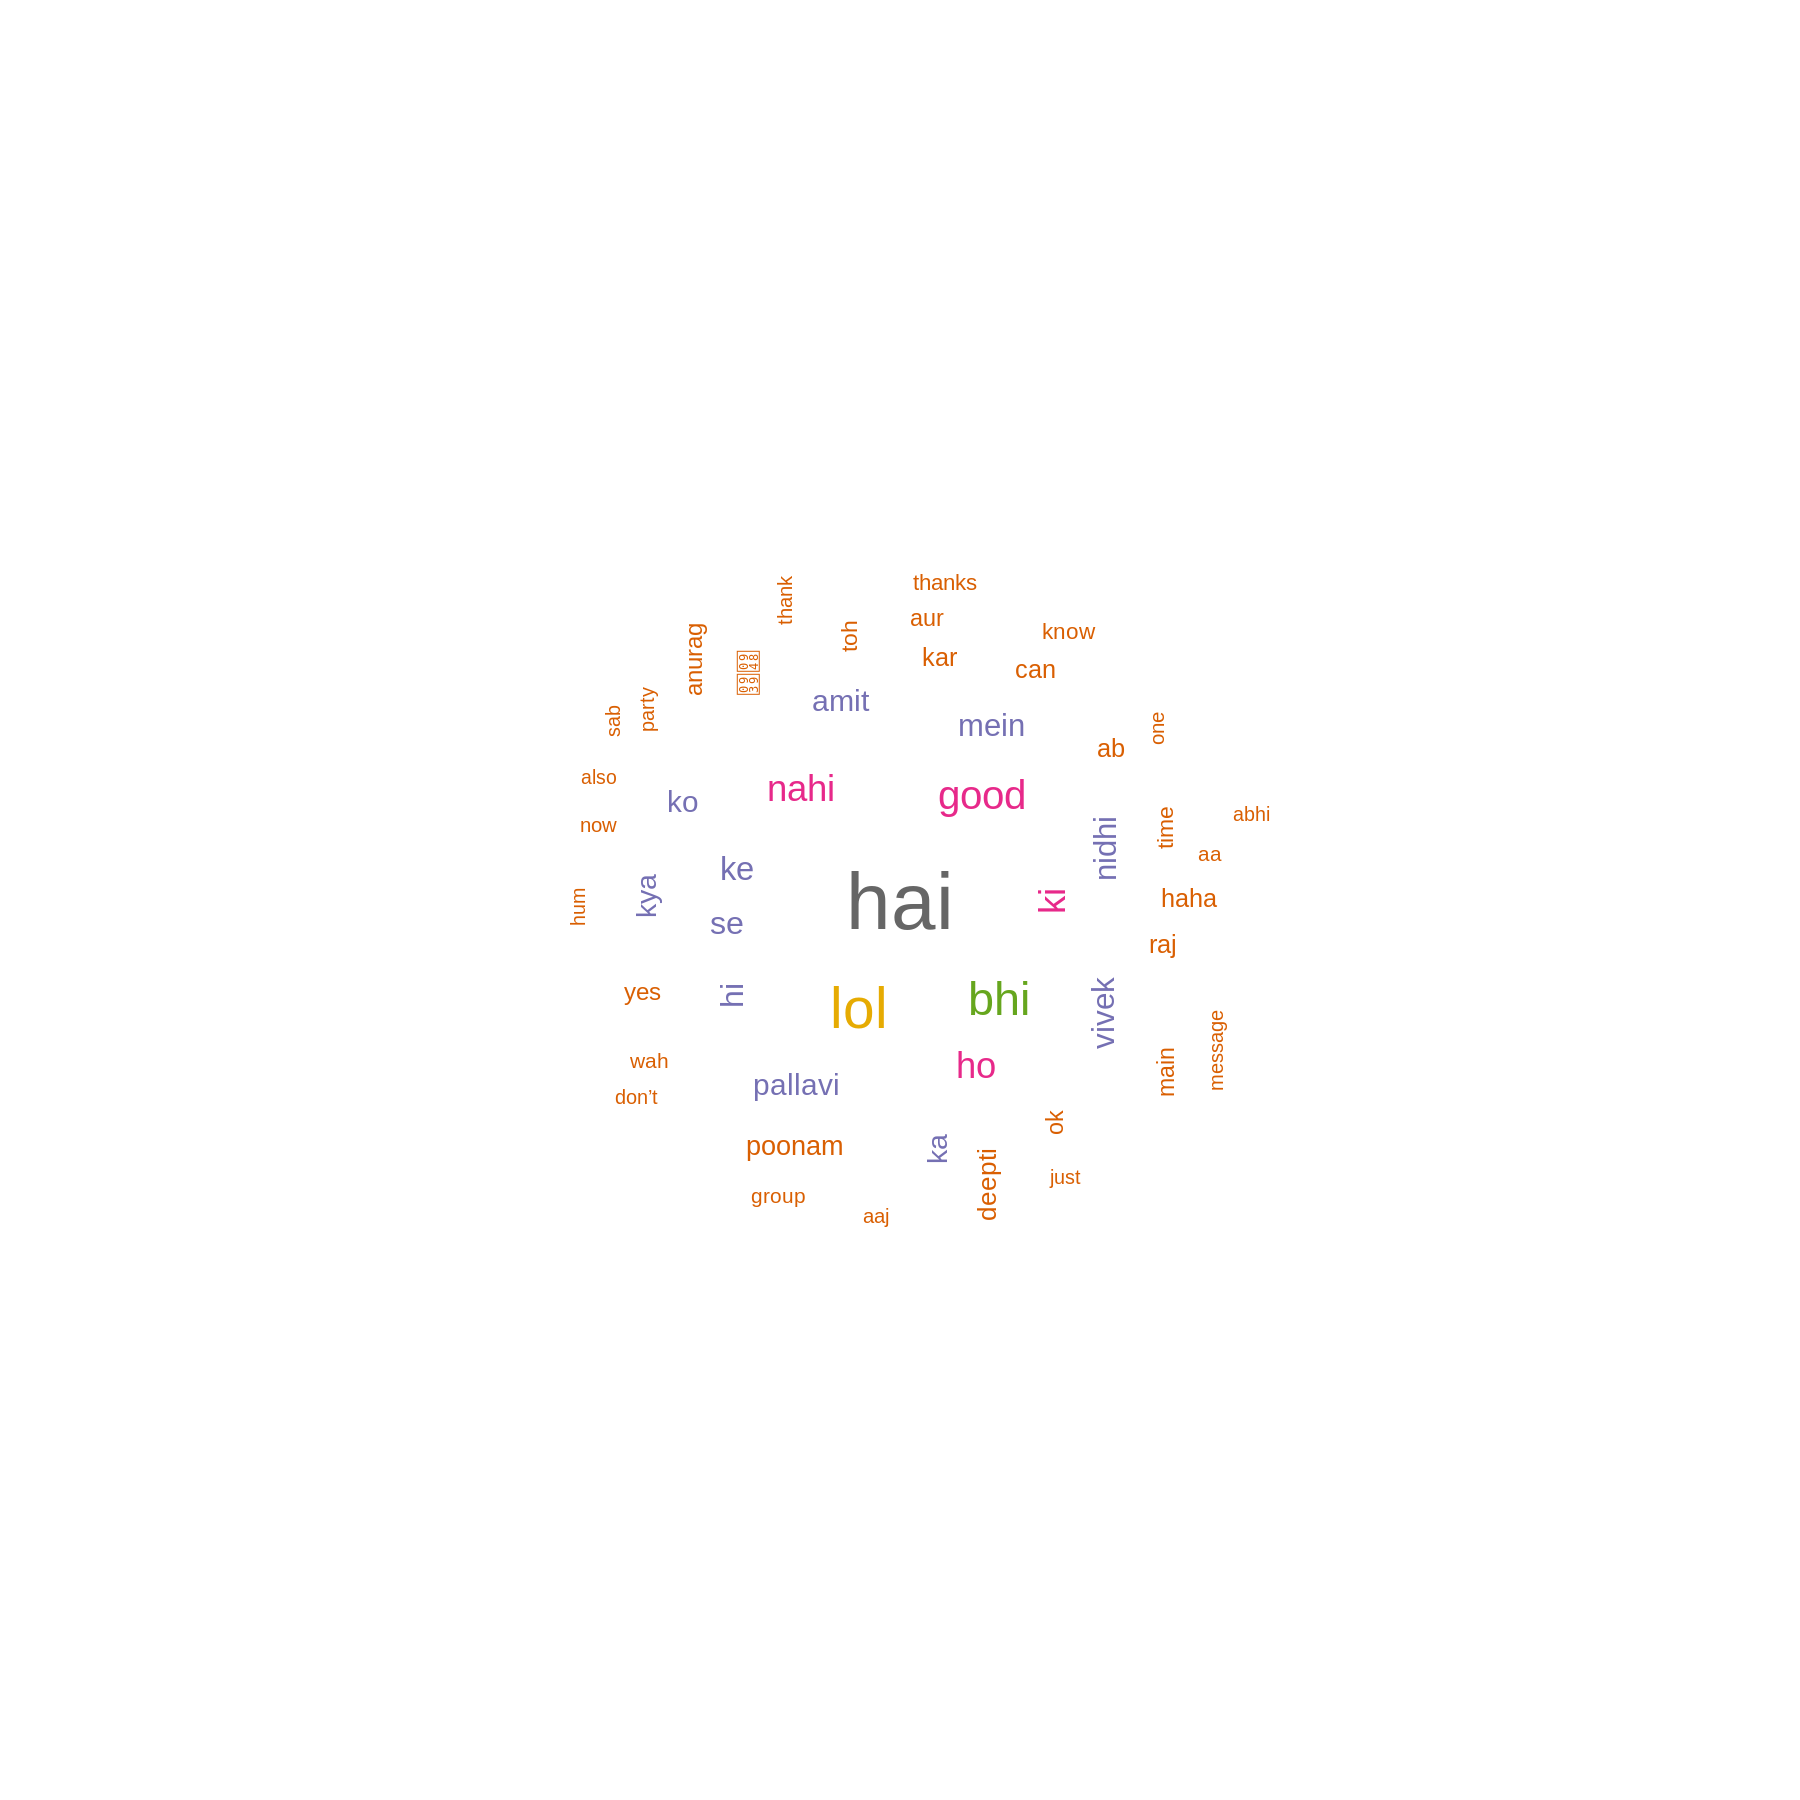

In [29]:

word_counts <- tidy_chat %>%
  count(word, sort=T) %>%
  filter(!(word %in% c("media", "omitted"))) %>%
  anti_join(get_stopwords()) %>%
  top_n(50) %>%
  ungroup()

wordcloud(words = word_counts$word, freq = word_counts$n, min.freq = 1,
          max.words=200, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))
